## MSMR analysis

In [4]:
## editing system path to enable the load of the modified impedance.py with NLEIS toolbox
import os.path
import sys
current_dir = os.path.dirname(os.path.abspath('__file__'))

# Get the parent directory by moving up one level
parent_dir = os.path.dirname(current_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import utilities.msmr as msmr
import utilities.plotting as mp

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from scipy.optimize import fmin_slsqp
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter as sf

plt.style.use('default')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob 
import re
from string import ascii_lowercase

In [6]:
def DOS_plot(Q,results,pos_lower_li_limit,neg_lower_li_limit,name):
# Setting up the whole plot, with the ylim being the ranges shown exclusive of the breaks
    ylim, ylim2 = [0.3, 0], [4.5, 3.5]
    ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
    ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
    gs = gridspec.GridSpec(2,1, height_ratios=[ylimratio,ylim2ratio])
    
    fig = plt.figure(figsize=(2.5,8))
    ax, ax2 = fig.add_subplot(gs[0]),  fig.add_subplot(gs[1])
 # calculate electrode response
    pos0_v, pos0_q, pos0_dqdu = msmr.electrode_response(results[0:18], 298, 3.4, 5, 6,3125)
    neg0_v, neg0_q, neg0_dqdu = msmr.electrode_response(results[18:], 298, 0, 1, 6, 5000)
    mask = np.array(-neg0_dqdu)<100
    
    ax.plot(-neg0_dqdu[mask], neg0_v[mask], 'k')
    ax2.plot(-pos0_dqdu, pos0_v, 'k')

    n_xlim = 20
    ax.spines['top'].set_visible(False), ax.spines['right'].set_visible(False)
    ax.set_xlim(0,n_xlim)
    ax2.spines['top'].set_visible(False), ax2.spines['right'].set_visible(False)
    p_xlim = 20
    ax2.set_xlim(0,p_xlim)
    ax.set_ylim(ylim), 
    ax.set_yticks([0,0.1,0.2, 0.3]), 
    ax.set_xticks([]), 

    ax.spines['bottom'].set_visible(False)
    # ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.set_ylim(ylim2), ax2.set_xticks([0,10,20]), ax2.xaxis.tick_bottom()
    
    # Putting in diagonals to denote the break in the y-axis
    d, d2 = .015, 1.75  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d*0.375, +d*0.375), **kwargs)        # top-left diagonal
    # ax.plot((1.03, 1.03), (0.6, 0.8), ls=':',lw  =2, **kwargs) # Dashed line at x = 20 to denote breaking
    
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d*0.375, 1 + d*0.375), **kwargs)  # bottom-left diagonal
    ## calculate whole cell response
    whole_cell_result = msmr.whole_cell(results, nor_pos = 6, nor_neg = 6,
                                    pos_lower_li_limit = pos_lower_li_limit, neg_lower_li_limit=neg_lower_li_limit,
                                    temp = 298, pos_volt_range = (3.4, 5), 
                                    neg_volt_range = (0, 1), p_capacity=None, n_p=None,
                                    usable_cap = Q.max(), Qj_or_Xj='Qj',all_output = True)

    full_v,pos_v,neg_v = whole_cell_result [1]
    full_q,pos_q,neg_q = whole_cell_result [0]

    full_dqdu,pos_dqdu,neg_dqdu = whole_cell_result [2]
    ####### 10%
    pos_v_10 = np.interp(3.5, full_v, np.flip(pos_v))
    neg_v_10 = np.interp(3.5, full_v, neg_v)
    fig.subplots_adjust(hspace=0.05)

    ####### 30%
    pos_v_30 = np.interp(3.64, full_v, np.flip(pos_v))
    neg_v_30 = np.interp(3.64, full_v, neg_v)

    ####### 50%
    pos_v_50 = np.interp(3.82, full_v, np.flip(pos_v))
    neg_v_50 = np.interp(3.82, full_v, neg_v)

    ## Anode 
    ax.fill_betweenx(neg0_v[neg0_v > neg_v_50], -neg0_dqdu[neg0_v > neg_v_50], 0 , color = '#CAF4FF', alpha = 1)
    # ax.fill_betweenx(neg0_v[neg0_v > neg_v_30], -neg0_dqdu[neg0_v > neg_v_30], 0 , color = '#87C4FF', alpha = 1)
    # ax.fill_betweenx(neg0_v[neg0_v > neg_v_10], -neg0_dqdu[neg0_v > neg_v_10], 0 , color = '#226E9C', alpha = 1)

    # ax.fill_betweenx(neg0_v[neg0_v > neg_v_50], -neg0_dqdu[neg0_v > neg_v_50], 0 , color = '#9EC9E2', alpha = 1)
    ax.fill_betweenx(neg0_v[neg0_v > neg_v_30], -neg0_dqdu[neg0_v > neg_v_30], 0 , color = '#6CB0D6', alpha = 1)
    ax.fill_betweenx(neg0_v[neg0_v > neg_v_10], -neg0_dqdu[neg0_v > neg_v_10], 0 , color = '#226E9C', alpha = 1)
    # Cathode
    ax2.fill_betweenx(pos0_v[pos0_v > pos_v_10], -pos0_dqdu[pos0_v > pos_v_10 ], 0 , color = '#EB4747', alpha = 1)
    ax2.fill_betweenx(pos0_v[pos0_v > pos_v_30], -pos0_dqdu[pos0_v > pos_v_30], 0 , color = '#FF8B8B', alpha =1)
    ax2.fill_betweenx(pos0_v[pos0_v > pos_v_50], -pos0_dqdu[pos0_v > pos_v_50], 0 , color = '#FFDEDE', alpha = 1)  

    ## calculate individual reaction response
    ## cathode
    voltage = np.linspace(3.4, 5, int((5-3.4)*3125)+1)
    N = len(voltage)
    xj = np.zeros((6,N)) 
    dxjdu = np.zeros((6,N)) 
    rxn = 6
    for i in range(0,rxn):
        xj[i,:], dxjdu[i,:] = msmr.individual_reactions(voltage, results[0+i*3], results[1+i*3], results[2+i*3], 298)
    ax2.plot(-dxjdu[0:4,:].T,voltage, color = 'C0')
    ax2.plot(-dxjdu[4:,:].T,voltage,'--',color = 'm')

    plt.show()
    fig.savefig('figures/'+name, dpi = 600,bbox_inches='tight')



## Data loading and preprocessing for 2.67C 25 degree 

In [7]:
stats_path = 'data/raw_cycling_data_stats/'
data_path = 'data/raw_cycling_data/'

In [8]:
files = glob.glob(data_path+'**/*.csv',  
                   recursive = True) 

In [9]:
cells_fresh = [51]
files_fresh = [file for file in files if any(f'Cell{cell} -' in file for cell in cells_fresh)]

cells_300 = [1]
files_300 = [file for file in files if any(f'Cell{cell} -' in file for cell in cells_300)]
cells_600 = [50]
files_600 = [file for file in files if any(f'Cell{cell} -' in file for cell in cells_600)]
cells_900 = [6]
files_900 = [file for file in files if any(f'Cell{cell} -' in file for cell in cells_900)]
cells_1500 = [11]
files_1500 = [file for file in files if any(f'Cell{cell} -' in file for cell in cells_1500)]

In [10]:
df_fresh = pd.read_csv(files_fresh[0])
df_300 = pd.read_csv(files_300[0])
df_600 = pd.read_csv(files_600[0])
df_900 = pd.read_csv(files_900[0])
df_1500 = pd.read_csv(files_1500[0])

In [7]:
df1 = df_fresh[df_fresh['Cyc#']==1]
df2 = df_300[df_300['Cyc#']==301]
df3 = df_600[df_600['Cyc#']==601]
df4 = df_900[df_900['Cyc#']==901]
df5 = df_1500[df_1500['Cyc#']==1501]

In [8]:
# Loading in voltage, current, capacity, dvdq, and the interpolated values for each cell
V = np.linspace(3.49, 4.15, 1000)

V_f, I_f, Q_f, dvdq_f, Q_interp_f, dvdq_interp_f = msmr.load_experiment_data(df1[df1['Step']==14], 0.075, 10, 99, V,charge=True) 
V_300, I_300, Q_300, dvdq_300, Q_interp_300, dvdq_interp_300 = msmr.load_experiment_data(df2[df2['Step']==29], 0.075, 10, 99, V,charge=True) 
V_600, I_600, Q_600, dvdq_600, Q_interp_600, dvdq_interp_600 = msmr.load_experiment_data(df3[df3['Step']==29], 0.075, 10, 99, V,charge=True) 
V_900, I_900, Q_900, dvdq_900, Q_interp_900, dvdq_interp_900 = msmr.load_experiment_data(df4[df4['Step']==29], 0.075, 10, 99, V,charge=True) 
V_1500, I_1500, Q_1500, dvdq_1500, Q_interp_1500, dvdq_interp_1500 = msmr.load_experiment_data(df5[df5['Step']==29], 0.075, 10, 99, V,charge=True) 

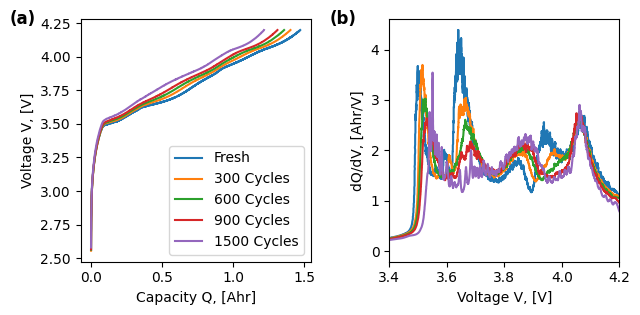

In [9]:
fig = plt.figure(figsize=(6.5,3.25))
ax, ax2 = fig.add_subplot(121), fig.add_subplot(122)

ax.plot(Q_f, V_f, label='Fresh')
ax.plot(Q_300, V_300,label='300 Cycles')
ax.plot(Q_600, V_600, label='600 Cycles')
ax.plot(Q_900, V_900, label='900 Cycles')
ax.plot(Q_1500, V_1500, label='1500 Cycles')


ax2.plot(V_f, 1/dvdq_f)
ax2.plot(V_300, 1/dvdq_300)
ax2.plot(V_600, 1/dvdq_600)
ax2.plot(V_900, 1/dvdq_900)
ax2.plot(V_1500, 1/dvdq_1500)

ax.set_xlabel('Capacity Q, [Ahr]')
ax.set_ylabel('Voltage V, [V]')
ax.legend()

ax2.set_xlabel('Voltage V, [V]')
ax2.set_ylabel('dQ/dV, [Ahr/V]')
ax2.set_xlim(3.4, 4.2)
ax.text(-0.25, 1, '(a)',horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, size=12, weight='bold')
ax2.text(-0.2, 1, '(b)',horizontalalignment='center',verticalalignment='center', transform=ax2.transAxes, size=12, weight='bold')

plt.tight_layout()
plt.show()
fig.savefig('figures/SI/Figure_S2.png', dpi = 300)

## Slippage Analysis

### Seeding paramaeters and model initialization

In [10]:
# Assuming NMC capacity is ~ 180 mAh, LiMNO is 130
# We collected XRD and EPS data to show us that our electrodes are roughly 66% NMC and 34% LMO
# From measurements, we estimate true insertion positive electrode capacity to be 1.8 Ahr.
# Assuming an N-P Ratio of 1.1

nmc_cap, lmo_cap = 200, 120 # mAh/g # , 120 mAh/g # Source = Nitta (2017)
nmc_mass_percent, lmo_mass_percent = 0.66, 0.34
pos_q, n_p, nor_pos, nor_neg  = 1.8, 1.1, 6, 6
neg_q = pos_q*n_p

nmc_cap_percent = (nmc_mass_percent*nmc_cap)/(nmc_mass_percent*nmc_cap + lmo_mass_percent*lmo_cap)
lmo_cap_percent = (lmo_mass_percent*lmo_cap)/(nmc_mass_percent*nmc_cap + lmo_mass_percent*lmo_cap)

# Base parameters from Verbrugge et al. (2017)
blend_matrix = np.array([3.62274, 0.13442*nmc_cap_percent*pos_q, 0.96710,
                         3.72645, 0.32460*nmc_cap_percent*pos_q, 1.39712,
                         3.90575, 0.21118*nmc_cap_percent*pos_q, 3.50500,
                         4.22955, 0.32980*nmc_cap_percent*pos_q, 5.52757,
                         4.01173, 0.55070*lmo_cap_percent*pos_q, 1.52000,
                         4.14902, 0.44930*lmo_cap_percent*pos_q, 0.93000])

graphite_matrix = np.array([0.08843, 0.43336*neg_q, 0.08611,
                            0.12799, 0.23963*neg_q, 0.08009,
                            0.14331, 0.15018*neg_q, 0.72469,
                            0.16984, 0.05462*neg_q, 2.53277,
                            0.21446, 0.06744*neg_q, 0.09470,
                            0.36325, 0.05476*neg_q, 5.97354])

# Total parameter matrix
params = np.append(blend_matrix.flatten(), graphite_matrix.flatten())

/Users/yuefanji/Desktop/2nd_NLEIS_manuscript/Part IV/Final_Notebook_folder/utilities/msmr.py:91: RuntimeWarning: overflow encountered in square
  dxjdu = (-Xj/w)*((f*np.exp(f*(U-U0)/w))/(1+np.exp(f*(U-U0)/w))**2)


0.185 0.001


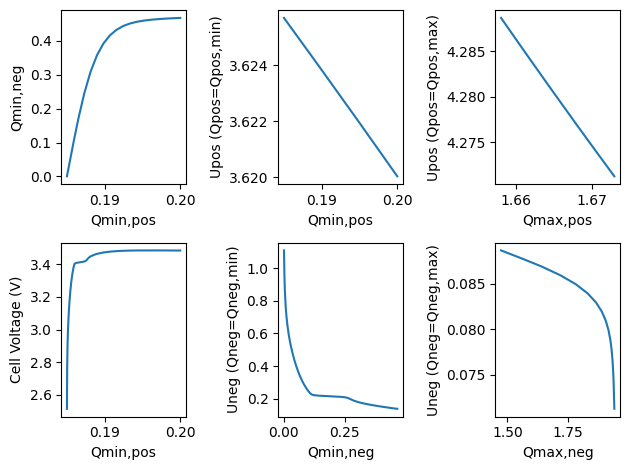

In [11]:
usable_cap = Q_f.max()
lower_v_limit, upper_v_limit = V_f.min(), V_f.max()
blend_volt, blend_cap, blend_dqdu = msmr.electrode_response(blend_matrix, 298, 3.4, 5, 6)
graph_volt, graph_cap, graph_dqdu = msmr.electrode_response(graphite_matrix, 298, 0, 1, 6)
f_pos_cap_interp = interp1d(blend_cap, blend_volt, fill_value='extrapolate')
f_neg_cap_interp = interp1d(graph_cap, graph_volt, fill_value='extrapolate')

f_pos_v_interp = interp1d(blend_volt, blend_cap, fill_value='extrapolate')
f_neg_v_interp = interp1d(graph_volt, graph_cap, fill_value='extrapolate')

pos_low_li_np = np.linspace(0.185, 0.2, 1000)

pos_low_li_lims, neg_low_li_lims = np.array([]), np.array([])
pos_high_li_lims, neg_high_li_lims = pos_low_li_lims + usable_cap, np.array([])
pos_upp_vs, neg_low_vs = np.array([]), np.array([])
pos_low_vs, neg_upp_vs = np.array([]), np.array([])
lower_voltages = np.array([])

for i in pos_low_li_np:
    pos_upper_v = f_pos_cap_interp(i+usable_cap) # Lower voltage because higher fill
    pos_lower_v = f_pos_cap_interp(i) # Higher voltage because lower fill
    neg_upper_v = pos_lower_v - upper_v_limit # Calculates 4.2 V
    if neg_upper_v < 0: # If the resulting negative voltage is negative, is invalid and moves on
        pass
    elif neg_upper_v >= 0: # If valid, goes and calculates the Q value associated with it
        neg_upper_q = f_neg_v_interp(neg_upper_v)
        neg_lower_q = neg_upper_q - usable_cap # Substracts usable Q from upper Q value
        neg_lower_v = f_neg_cap_interp(neg_lower_q) # Calculates the voltage at the lower Q value
        min_v = pos_upper_v - neg_lower_v # Calculates the voltage at 100% SoC
        if neg_lower_q < 0: # If the lower Q value is negative, result is invalid and moves on
            pass
        elif neg_lower_q >= 0: # If valid, records all data
            pos_low_li_lims, neg_low_li_lims = np.append(pos_low_li_lims, i), np.append(neg_low_li_lims, neg_lower_q)
            pos_high_li_lims, neg_high_li_lims = np.append(pos_high_li_lims, (i+usable_cap)), np.append(neg_high_li_lims, neg_upper_q)
            neg_low_vs, neg_upp_vs = np.append(neg_low_vs, neg_lower_v), np.append(neg_upp_vs, neg_upper_v)
            pos_upp_vs, pos_low_vs = np.append(pos_upp_vs, pos_upper_v), np.append(pos_low_vs, pos_lower_v)
            lower_voltages = np.append(lower_voltages, min_v)

fig = plt.figure()
ax1, ax2, ax3 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233), 
ax4, ax5, ax6 = fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236) 
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

ax1.plot(pos_low_li_lims, neg_low_li_lims)
ax2.plot(pos_low_li_lims, pos_upp_vs)
ax3.plot(pos_high_li_lims, pos_low_vs)
ax4.plot(pos_low_li_lims, lower_voltages)
ax5.plot(neg_low_li_lims, neg_low_vs)
ax6.plot(neg_high_li_lims, neg_upp_vs)
    
ax1.set_ylabel('Qmin,neg'), ax1.set_xlabel('Qmin,pos')
ax2.set_xlabel('Qmin,pos'), ax2.set_ylabel('Upos (Qpos=Qpos,min)')
ax3.set_xlabel('Qmax,pos'), ax3.set_ylabel('Upos (Qpos=Qpos,max)')
ax4.set_xlabel('Qmin,pos'), ax4.set_ylabel('Cell Voltage (V)')
ax5.set_xlabel('Qmin,neg'), ax5.set_ylabel('Uneg (Qneg=Qneg,min)')
ax6.set_xlabel('Qmax,neg'), ax6.set_ylabel('Uneg (Qneg=Qneg,max)')
plt.tight_layout()

posin, negin = interp1d(lower_voltages, pos_low_li_lims), interp1d(lower_voltages, neg_low_li_lims)

pos_lower_lim_c = np.round(posin(V_f.min()), 3)
neg_lower_lim_c = np.round(negin(V_f.min()), 3)
print(pos_lower_lim_c, neg_lower_lim_c)

## Fitting

In [12]:
# Fresh guess for the charge data
pos_c, neg_c = 1.8, 1.98

# Take the Xj form of the initial guess and multiply it by the initial guesses of the 
# total electrode capacities

fresh_guess = np.array([3.6827400e+00, 1.0268194e-01*pos_c, 9.6710000e-01, # Positive Electrode
                        3.7264500e+00, 2.4795833e-01*pos_c, 1.3971200e+00, 
                        3.9057500e+00, 1.6131806e-01*pos_c, 3.5050000e+00, 
                        4.2605500e+00, 2.5193056e-01*pos_c, 5.5275700e+00,
                        4.0117300e+00, 1.3002639e-01*pos_c, 1.5200000e+00, 
                        4.1690200e+00, 1.0608472e-01*pos_c, 9.3000000e-01, 
                        
                        7.5430000e-02, 5.7137000e-01*neg_c, 8.6110000e-02, # Negative Electrode
                        1.0299000e-01, 2.5463000e-01*neg_c, 8.0090000e-02,
                        1.2431000e-01, 2.4680000e-02*neg_c, 1.5000000e-01, 
                        1.4634000e-01, 2.7120000e-02*neg_c, 1.7500000e-01, 
                        1.6846000e-01, 6.7440000e-02*neg_c, 1.2200000e-01, 
                        3.6325000e-01, 5.4760000e-02*neg_c, 5.9735400e+00,
                        
                        0.185, 0.00098]) # Lower Lithiation Bounds

### Fresh

In [13]:
pos_lower_lim_c = np.round(posin(V_f.min()), 3)
neg_lower_lim_c = np.round(negin(V_f.min()), 3)

# Bounds for each parameter
# Setting +/- 20 mV bounds for U0j, and +/- 25% bounds for Qj_tot and w_j
fresh_ocv_bounds = []
for i in range(0,int(nor_pos+nor_neg)):
    fresh_ocv_bounds.append((fresh_guess[i*3] - 0.02, fresh_guess[i*3] + 0.02))
    fresh_ocv_bounds.append((fresh_guess[i*3 + 1]*0.75, fresh_guess[i*3 + 1]*1.25))
    fresh_ocv_bounds.append((fresh_guess[i*3 + 2]*0.75, fresh_guess[i*3 + 2]*1.25))

fresh_ocv_bounds.append((0.09, 0.185)) # Bounds for Qj_upper_pos
fresh_ocv_bounds.append((0, 0.0108)) # Bounds for Qj_upper_neg

# Ensuring that the Qj_tot values for the LMO components are +/- 5% to match experimental data
fresh_ocv_bounds[13] = (fresh_guess[13]*0.95, fresh_guess[13]*1.05)
fresh_ocv_bounds[16] = (fresh_guess[16]*0.95, fresh_guess[16]*1.05)

# Fitting Component

results_f = fmin_slsqp(func=msmr.verbrugge_whole_cell_opt, x0=fresh_guess, 
                        args=(V,             # interpolated voltage range
                              Q_interp_f,       # interpolated capacity data
                              dvdq_interp_f,     # interpolated dvdq data
                              V_f.min(),   # Minimum voltage
                              V_f.max(),   # Maximum voltage
                              298,                       # temperature
                              6, 6,                      # number of pos rxns, number of neg rxns
                              (3.4,5), (0,1),            # positive voltage range, negative voltange range
                              pos_lower_lim_c, neg_lower_lim_c,                 # positive | neg lower X or Q limit
                              None,                      # N|P Ratio
                              None,                      # positive electrode full capacity
                              Q_f.max(),  # usable/cyclable capacity within the voltage limits
                              'Qj', 'MAE',              # Qj or Xj
                              None,                      # list of pos_U0s
                              None,                      # list of neg_U0s
                              False, True,               # fixed voltage | fixed Xj or Qj limit
                              0.5, 0.5),                 # capacity vs dvdq weight on error function
                        eqcons=[msmr.lower_v_constraint, msmr.upper_v_constraint],
                        bounds=fresh_ocv_bounds, iter=500, full_output=False)

print(results_f)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.021858207935926192
            Iterations: 95
            Function evaluations: 3748
            Gradient evaluations: 95
[3.66274000e+00 2.31034365e-01 7.25325000e-01 3.74400054e+00
 3.90679843e-01 1.04784000e+00 3.88575000e+00 3.08399053e-01
 2.62878294e+00 4.25915971e+00 3.88693888e-01 4.14567750e+00
 4.01645548e+00 2.22345127e-01 1.48298518e+00 4.14902000e+00
 1.81404871e-01 1.12193776e+00 7.28744711e-02 1.26385200e+00
 1.07637500e-01 1.03328098e-01 5.47813920e-01 1.00112500e-01
 1.27305111e-01 6.10830000e-02 1.81544469e-01 1.49220288e-01
 6.37113167e-02 2.18750000e-01 1.72511815e-01 1.61785334e-01
 1.52500000e-01 3.43250000e-01 8.13186000e-02 6.72732765e+00
 1.85000000e-01 9.80000000e-04]


In [14]:
print ('U0j')
np.round(results_f[0::3],3)

U0j


array([3.663, 3.744, 3.886, 4.259, 4.016, 4.149, 0.073, 0.103, 0.127,
       0.149, 0.173, 0.343, 0.185])

In [15]:
print ('Qj_tot')
np.round(results_f[1::3],3)

Qj_tot


array([2.310e-01, 3.910e-01, 3.080e-01, 3.890e-01, 2.220e-01, 1.810e-01,
       1.264e+00, 5.480e-01, 6.100e-02, 6.400e-02, 1.620e-01, 8.100e-02,
       1.000e-03])

In [16]:
print ('w_j')
np.round(results_f[2::3],3)

w_j


array([0.725, 1.048, 2.629, 4.146, 1.483, 1.122, 0.108, 0.1  , 0.182,
       0.219, 0.152, 6.727])

### 300 cycles

In [17]:
# Charge - 300 Cycles

# Setting bounds for each parameter
aged_300_ocv_bounds = []
for i in range(0,int(nor_pos+nor_neg)):
    aged_300_ocv_bounds.append((results_f[i*3] - 0.02, results_f[i*3] + 0.02))
    aged_300_ocv_bounds.append((results_f[i*3 + 1]*0.75, results_f[i*3 + 1]*1.25))
    aged_300_ocv_bounds.append((results_f[i*3 + 2]*0.75, results_f[i*3 + 2]*1.25))

aged_300_ocv_bounds.append((0.1, 0.185))
aged_300_ocv_bounds.append((0, 0.0108))
    
results_300 = fmin_slsqp(func=msmr.verbrugge_whole_cell_opt, x0=results_f, 
                         args=(V,        # interpolated voltage range
                               Q_interp_300,      # interpolated capacity data
                               dvdq_interp_300,     # interpolated dvdq data
                               V_300.min(),  # Minimum voltage
                               V_300.max(),  # Maximum voltage
                               298,                  # temperature
                               6, 6,                 # number of pos rxns, number of neg rxns
                               (3.4,5), (0,1),       # positive voltage range, negative voltange range
                               None,                 # positive lower X limit
                               None,                 # negative lower X limit
                               None,                 # N|P Ratio
                               None,                 # positive electrode full capacity
                               Q_300.max(), # usable/cyclable capacity within the voltage limits
                               'Qj', 'MAE',         # Qj or Xj
                               None,                 # list of pos_U0s
                               None,                 # list of neg_U0s
                               False,                # fixed voltage
                               False,                 # fixed xj_limit
                               0.5,                  # capacity weight on error function
                               0.5),                 # dvdq weight on error function
                         eqcons=[msmr.lower_v_constraint, msmr.upper_v_constraint],
                         bounds=aged_300_ocv_bounds, iter=500, full_output=False)

print(results_300)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.021028198787351585
            Iterations: 64
            Function evaluations: 2553
            Gradient evaluations: 64
[3.67693985e+00 2.88792956e-01 5.43993750e-01 3.74815802e+00
 3.63335412e-01 1.17059739e+00 3.90575000e+00 2.86871582e-01
 2.56590277e+00 4.23933580e+00 4.19180205e-01 3.83855218e+00
 3.99787650e+00 2.13855516e-01 1.85373147e+00 4.13079992e+00
 1.36053653e-01 9.48835303e-01 6.36174056e-02 1.28448913e+00
 1.34546875e-01 9.70282673e-02 5.39187624e-01 1.25140625e-01
 1.20861857e-01 4.74346976e-02 1.54199432e-01 1.40665021e-01
 7.03769470e-02 2.73437500e-01 1.67804829e-01 1.60759696e-01
 1.63702093e-01 3.23250000e-01 9.21894121e-02 6.72048617e+00
 1.85000000e-01 6.67426258e-04]


In [18]:
print ('U0j')
np.round(results_300[0::3],3)

U0j


array([3.677, 3.748, 3.906, 4.239, 3.998, 4.131, 0.064, 0.097, 0.121,
       0.141, 0.168, 0.323, 0.185])

In [19]:
print ('Qj_tot')
np.round(results_300[1::3],3)

Qj_tot


array([2.890e-01, 3.630e-01, 2.870e-01, 4.190e-01, 2.140e-01, 1.360e-01,
       1.284e+00, 5.390e-01, 4.700e-02, 7.000e-02, 1.610e-01, 9.200e-02,
       1.000e-03])

In [20]:
print ('w_j')
np.round(results_300[2::3],3)

w_j


array([0.544, 1.171, 2.566, 3.839, 1.854, 0.949, 0.135, 0.125, 0.154,
       0.273, 0.164, 6.72 ])

### 600 cycles

In [21]:
# Charge - 600 Cycles

# Setting bounds for each parameter
aged_600_ocv_bounds = []
for i in range(0,int(nor_pos+nor_neg)):
    aged_600_ocv_bounds.append((results_300[i*3] - 0.02, results_300[i*3] + 0.02))
    aged_600_ocv_bounds.append((results_300[i*3 + 1]*0.75, results_300[i*3 + 1]*1.25))
    aged_600_ocv_bounds.append((results_300[i*3 + 2]*0.75, results_300[i*3 + 2]*1.25))

aged_600_ocv_bounds.append((0.05, results_300[-2]))
aged_600_ocv_bounds.append((0, results_300[-1]))
    
results_600 = fmin_slsqp(func=msmr.verbrugge_whole_cell_opt, x0=results_300, 
                         args=(V,        # interpolated voltage range
                               Q_interp_600,      # interpolated capacity data
                               dvdq_interp_600,     # interpolated dvdq data
                               V_600.min(),  # Minimum voltage
                               V_600.max(),  # Maximum voltage
                               298,                  # temperature
                               6, 6,                 # number of pos rxns, number of neg rxns
                               (3.4,5), (0,1),       # positive voltage range, negative voltange range
                               None,                 # positive lower X limit
                               None,                 # negative lower X limit
                               None,                 # N|P Ratio
                               None,                 # positive electrode full capacity
                               Q_600.max(), # usable/cyclable capacity within the voltage limits
                               'Qj', 'MAE',         # Qj or Xj
                               None,                 # list of pos_U0s
                               None,                 # list of neg_U0s
                               False,                # fixed voltage
                               False,                 # fixed xj_limit
                               0.5,                  # capacity weight on error function
                               0.5),                 # dvdq weight on error function
                         eqcons=[msmr.lower_v_constraint, msmr.upper_v_constraint],
                         bounds=aged_600_ocv_bounds, iter=500, full_output=False)

print(results_600)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.01809828107729853
            Iterations: 83
            Function evaluations: 3321
            Gradient evaluations: 83
[3.68481052e+00 2.46768147e-01 4.07995313e-01 3.76815802e+00
 3.14325327e-01 1.24454314e+00 3.92575000e+00 2.15153686e-01
 2.64441715e+00 4.21933580e+00 4.22054849e-01 3.86442125e+00
 3.97787650e+00 2.40369111e-01 1.96071402e+00 4.13126358e+00
 1.31310766e-01 8.82191201e-01 6.53496082e-02 1.28992686e+00
 1.68183594e-01 1.02990402e-01 5.43045812e-01 1.56302674e-01
 1.26883349e-01 5.67124179e-02 1.92749290e-01 1.40012180e-01
 8.06313383e-02 3.41796875e-01 1.63697217e-01 1.42373347e-01
 2.04627616e-01 3.03250000e-01 8.79981486e-02 6.53735823e+00
 1.62985550e-01 5.48268058e-04]


In [22]:
print ('U0j')
np.round(results_600[0::3],3)

U0j


array([3.685, 3.768, 3.926, 4.219, 3.978, 4.131, 0.065, 0.103, 0.127,
       0.14 , 0.164, 0.303, 0.163])

In [23]:
print ('Qj_tot')
np.round(results_600[1::3],3)

Qj_tot


array([2.47e-01, 3.14e-01, 2.15e-01, 4.22e-01, 2.40e-01, 1.31e-01,
       1.29e+00, 5.43e-01, 5.70e-02, 8.10e-02, 1.42e-01, 8.80e-02,
       1.00e-03])

In [24]:
print ('w_j')
np.round(results_600[2::3],3)

w_j


array([0.408, 1.245, 2.644, 3.864, 1.961, 0.882, 0.168, 0.156, 0.193,
       0.342, 0.205, 6.537])

### 900 cycles

In [25]:

# Charge - 900 Cycles

# Setting bounds for each parameter
aged_900_ocv_bounds = []
for i in range(0,int(nor_pos+nor_neg)):
    aged_900_ocv_bounds.append((results_600[i*3] - 0.02, results_600[i*3] + 0.02))
    aged_900_ocv_bounds.append((results_600[i*3 + 1]*0.75, results_600[i*3 + 1]*1.25))
    aged_900_ocv_bounds.append((results_600[i*3 + 2]*0.75, results_600[i*3 + 2]*1.25))

aged_900_ocv_bounds.append((0.03, results_600[-2]))
aged_900_ocv_bounds.append((0, results_600[-1]))
    
results_900 = fmin_slsqp(func=msmr.verbrugge_whole_cell_opt, x0=results_600, 
                         args=(V,        # interpolated voltage range
                               Q_interp_900,      # interpolated capacity data
                               dvdq_interp_900,     # interpolated dvdq data
                               V_900.min(),  # Minimum voltage
                               V_900.max(),  # Maximum voltage
                               298,                  # temperature
                               6, 6,                 # number of pos rxns, number of neg rxns
                               (3.4,5), (0,1),       # positive voltage range, negative voltange range
                               None,                 # positive lower X limit
                               None,                 # negative lower X limit
                               None,                 # N|P Ratio
                               None,                 # positive electrode full capacity
                               Q_900.max(), # usable/cyclable capacity within the voltage limits
                               'Qj', 'MAE',         # Qj or Xj
                               None,                 # list of pos_U0s
                               None,                 # list of neg_U0s
                               False,                # fixed voltage
                               False,                 # fixed xj_limit
                               0.5,                  # capacity weight on error function
                               0.5),                 # dvdq weight on error function
                         eqcons=[msmr.lower_v_constraint, msmr.upper_v_constraint],
                         bounds=aged_900_ocv_bounds, iter=500, full_output=False)

print(results_900)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.01058524170934773
            Iterations: 122
            Function evaluations: 4857
            Gradient evaluations: 122
[3.67830327e+00 2.03398917e-01 5.09994141e-01 3.76758103e+00
 3.24891695e-01 1.55567892e+00 3.90575000e+00 2.68942108e-01
 3.23764003e+00 4.19933580e+00 4.01356632e-01 3.50758398e+00
 3.98316045e+00 2.09632204e-01 1.51820711e+00 4.13950337e+00
 1.13291459e-01 7.13094108e-01 6.95815863e-02 1.35289660e+00
 2.10229492e-01 1.10856217e-01 5.44123245e-01 1.95378342e-01
 1.38819560e-01 4.25343135e-02 1.64587860e-01 1.58140912e-01
 6.04735037e-02 4.27246094e-01 1.58853084e-01 1.31432352e-01
 1.53470712e-01 2.98224427e-01 1.09997686e-01 4.90301867e+00
 1.25822736e-01 9.61272718e-05]


In [26]:
print ('U0j')
np.round(results_900[0::3],3)

U0j


array([3.678, 3.768, 3.906, 4.199, 3.983, 4.14 , 0.07 , 0.111, 0.139,
       0.158, 0.159, 0.298, 0.126])

In [27]:
print ('Qj_tot')
np.round(results_900[1::3],3)

Qj_tot


array([0.203, 0.325, 0.269, 0.401, 0.21 , 0.113, 1.353, 0.544, 0.043,
       0.06 , 0.131, 0.11 , 0.   ])

In [28]:
print ('w_j')
np.round(results_900[2::3],3)

w_j


array([0.51 , 1.556, 3.238, 3.508, 1.518, 0.713, 0.21 , 0.195, 0.165,
       0.427, 0.153, 4.903])

### 1500 cycles

In [29]:
# Charge - 1500 Cycles

# Setting bounds for each parameter
aged_1500_ocv_bounds = []
for i in range(0,int(nor_pos+nor_neg)):
    aged_1500_ocv_bounds.append((results_900[i*3] - 0.02, results_900[i*3] + 0.02))
    aged_1500_ocv_bounds.append((results_900[i*3 + 1]*0.75, results_900[i*3 + 1]*1.25))
    aged_1500_ocv_bounds.append((results_600[i*3 + 2]*0.75, results_900[i*3 + 2]*1.25))

aged_1500_ocv_bounds.append((0, results_900[-2]))
aged_1500_ocv_bounds.append((0, results_900[-1]))
    
results_1500 = fmin_slsqp(func=msmr.verbrugge_whole_cell_opt, x0=results_900, 
                         args=(V,        # interpolated voltage range
                               Q_interp_1500,      # interpolated capacity data
                               dvdq_interp_1500,     # interpolated dvdq data
                               V_1500.min(),  # Minimum voltage
                               V_1500.max(),  # Maximum voltage
                               298,                  # temperature
                               6, 6,                 # number of pos rxns, number of neg rxns
                               (3.4,5), (0,1),       # positive voltage range, negative voltange range
                               None,                 # positive lower X limit
                               None,                 # negative lower X limit
                               None,                 # N|P Ratio
                               None,                 # positive electrode full capacity
                               Q_1500.max(), # usable/cyclable capacity within the voltage limits
                               'Qj', 'MAE',         # Qj or Xj
                               None,                 # list of pos_U0s
                               None,                 # list of neg_U0s
                               False,                # fixed voltage
                               False,                 # fixed xj_limit
                               0.5,                  # capacity weight on error function
                               0.5),                 # dvdq weight on error function
                         eqcons=[msmr.lower_v_constraint, msmr.upper_v_constraint],
                         bounds=aged_1500_ocv_bounds, iter=500, full_output=False)

print(results_1500)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.021496720461676888
            Iterations: 56
            Function evaluations: 2229
            Gradient evaluations: 56
[3.69830327e+00 2.54248647e-01 5.97800903e-01 3.78071781e+00
 2.50175166e-01 1.71844087e+00 3.88575000e+00 2.86786662e-01
 3.20687122e+00 4.21933580e+00 3.59600058e-01 3.49691969e+00
 3.99812634e+00 2.26428314e-01 1.47053551e+00 4.15561543e+00
 1.39351549e-01 7.37477797e-01 8.80440634e-02 1.35206351e+00
 1.26137695e-01 1.26109162e-01 6.32281332e-01 2.01161766e-01
 1.57539424e-01 4.15005694e-02 1.78155534e-01 1.72267429e-01
 4.53551278e-02 5.34057617e-01 1.77515635e-01 1.29963814e-01
 1.53470712e-01 2.78224427e-01 1.33857313e-01 4.90301867e+00
 1.12443322e-01 2.46518669e-05]


In [30]:
print ('U0j')
np.round(results_1500[0::3],3)

U0j


array([3.698, 3.781, 3.886, 4.219, 3.998, 4.156, 0.088, 0.126, 0.158,
       0.172, 0.178, 0.278, 0.112])

In [31]:
print ('Qj_tot')
np.round(results_1500[1::3],3)

Qj_tot


array([0.254, 0.25 , 0.287, 0.36 , 0.226, 0.139, 1.352, 0.632, 0.042,
       0.045, 0.13 , 0.134, 0.   ])

In [32]:
print ('w_j')
np.round(results_1500[2::3],3)

w_j


array([0.598, 1.718, 3.207, 3.497, 1.471, 0.737, 0.126, 0.201, 0.178,
       0.534, 0.153, 4.903])

## Visualization

### Fresh

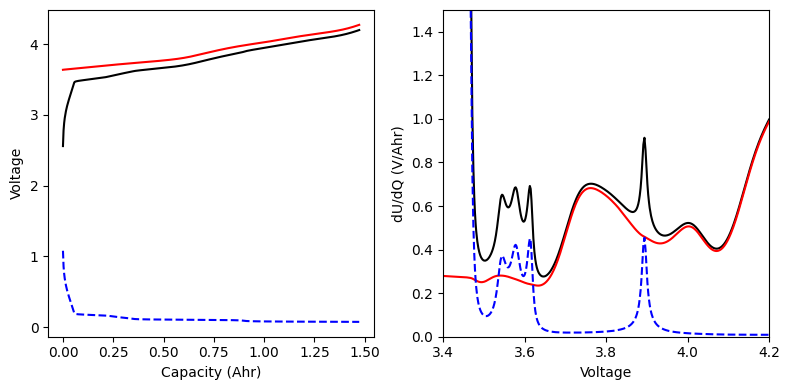

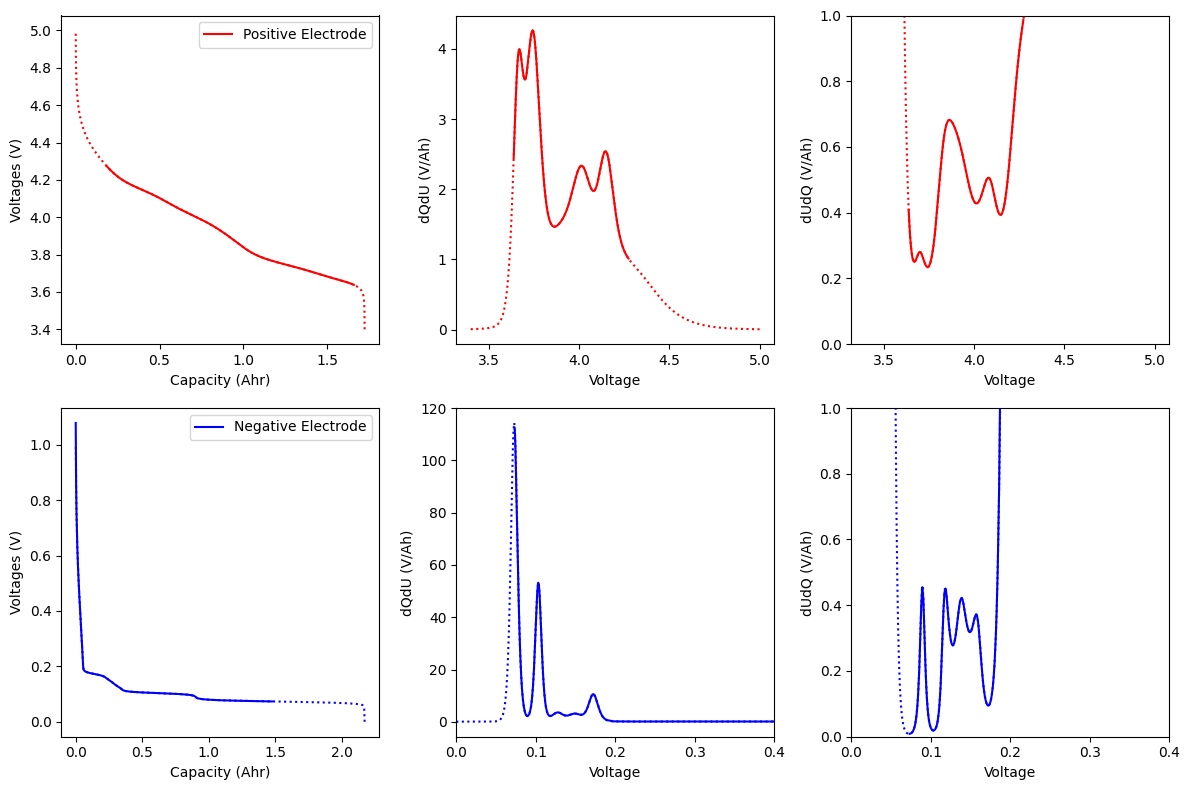

In [33]:
# 0 Cycles
guess_f = results_f[0:(3*(nor_pos+nor_neg))]

model_results_f = msmr.whole_cell(guess_f, nor_pos = 6, nor_neg = 6,
                                pos_lower_li_limit = 0.185006060, neg_lower_li_limit=0.00098081,
                                temp = 298, pos_volt_range = (3.4, 5), 
                                neg_volt_range = (0, 1), p_capacity=None, n_p=None,
                                usable_cap = Q_f.max(), Qj_or_Xj='Qj', all_output=True)

pos_whole_0 = msmr.electrode_response(guess_f[0:18], 298, 3.4, 5, 6)
neg_whole_0 = msmr.electrode_response(guess_f[18:36], 298, 0, 1, 6)

fig_1_0, fig_2_0 = mp.individual_electrode_analysis(model_results_f, pos_whole_0, neg_whole_0)


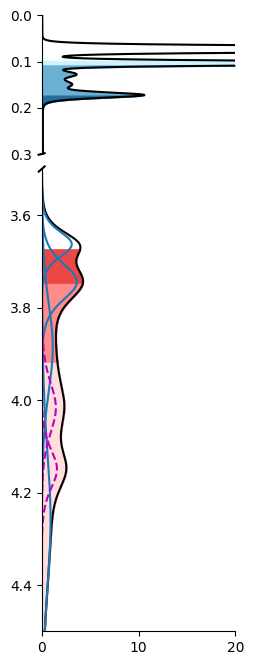

In [34]:
DOS_plot(Q_f,guess_f,0.185006060,0.00098081,'fresh_dos_charge.png')

#### MAE

In [35]:
whole_cell_f = msmr.whole_cell(guess_f, nor_pos = 6, nor_neg = 6,
                                pos_lower_li_limit = 0.185006060, neg_lower_li_limit=0.00098081,
                                temp = 298, pos_volt_range = (3.4, 5), 
                                neg_volt_range = (0, 1), p_capacity=None, n_p=None,
                                usable_cap = Q_f.max(), Qj_or_Xj='Qj')


In [36]:
# fit0_51_mae_c = 
capacity_range_f = np.linspace(Q_f.min(), Q_f.max(), 1000)
print ('Voltage profile MAE: ', msmr.mae(V_f, whole_cell_f[1], whole_cell_f[0], Q_f, capacity_range_f))
print ('dVdQ MAE: ',msmr.mae(dvdq_f, -whole_cell_f[3], whole_cell_f[1], V_f, V))
print ('dQdV MAE: ',msmr.mae(1/dvdq_f, -1/whole_cell_f[3], whole_cell_f[1], V_f, V))

Voltage profile MAE:  0.003600023031229534
dVdQ MAE:  0.022504796179250306
dQdV MAE:  0.09130518695607157


/Users/yuefanji/opt/anaconda3/envs/nleis/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/yuefanji/opt/anaconda3/envs/nleis/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:482: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


### 300 Cycles

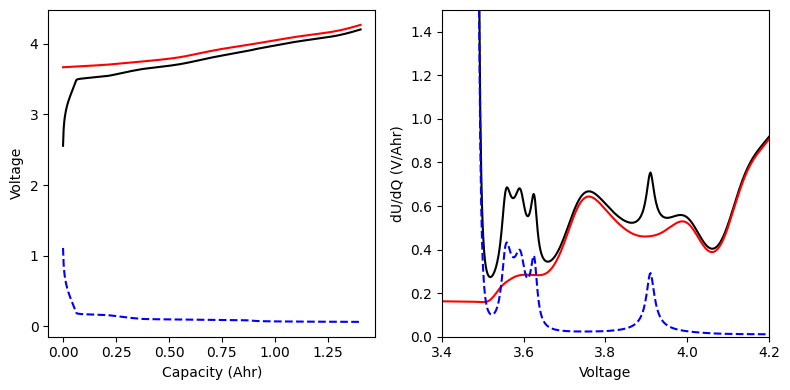

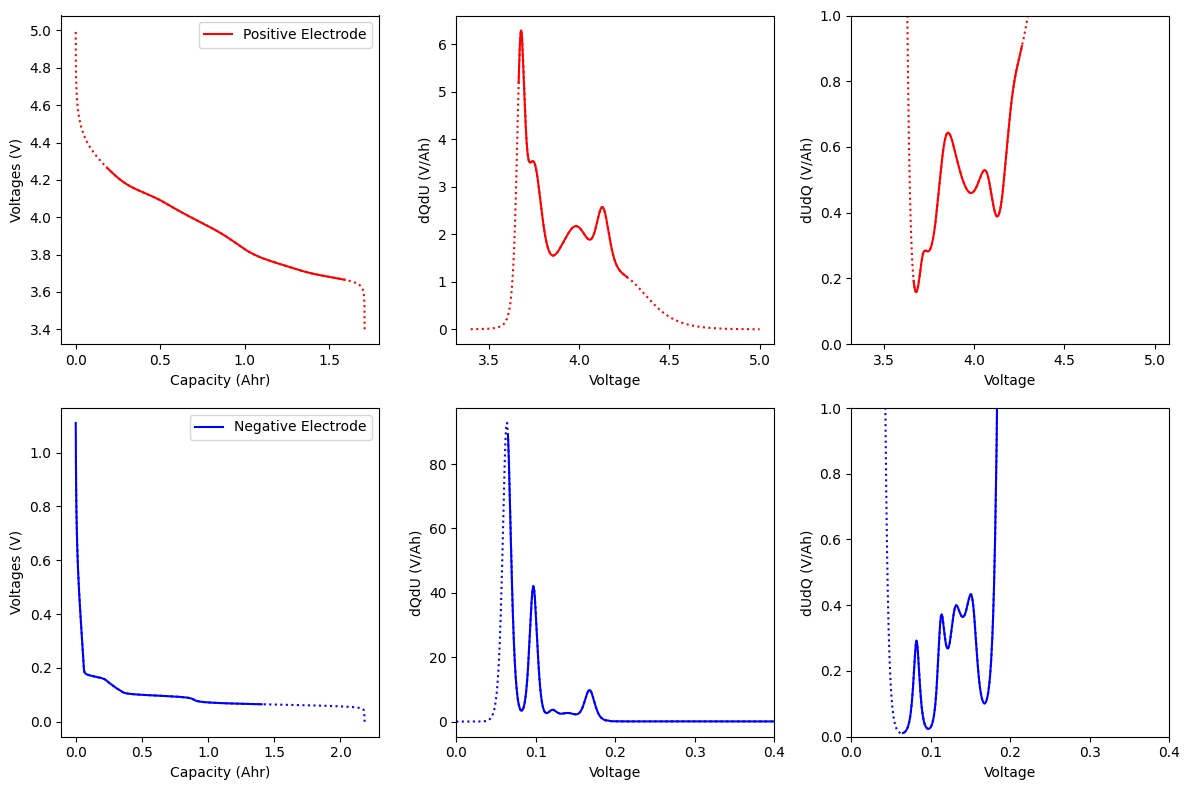

In [37]:
# 300 Cycles
guess_300 = results_300[0:(3*(nor_pos+nor_neg))]

model_results_300 = msmr.whole_cell(guess_300, nor_pos = 6, nor_neg = 6, 
                                 pos_lower_li_limit = results_300[-2], neg_lower_li_limit = results_300[-1],
                                 temp = 298, pos_volt_range = (3.4, 5), neg_volt_range = (0, 1), 
                                 usable_cap = Q_300.max(), n_p=None, p_capacity=None,
                                 Qj_or_Xj='Qj', all_output=True)

pos_whole_300 = msmr.electrode_response(guess_300[0:18], 298, 3.4, 5, 6)
neg_whole_300 = msmr.electrode_response(guess_300[18:36], 298, 0, 1, 6)

fig_1_300, fig_2_300 = mp.individual_electrode_analysis(model_results_300, pos_whole_300, neg_whole_300)

#### MAE

In [38]:
whole_cell_300 = msmr.whole_cell(guess_300, nor_pos = 6, nor_neg = 6, 
                                 pos_lower_li_limit = results_300[-2], neg_lower_li_limit = results_300[-1],
                                 temp = 298, pos_volt_range = (3.4, 5), neg_volt_range = (0, 1), 
                                 usable_cap = Q_300.max(), n_p=None, p_capacity=None,
                                 Qj_or_Xj='Qj')

In [39]:
# fit0_51_mae_c = 
capacity_range_300 = np.linspace(Q_300.min(), Q_300.max(), 1000)
print ('Voltage profile MAE: ', msmr.mae(V_300, whole_cell_300[1], whole_cell_300[0], Q_300, capacity_range_300))
print ('dVdQ MAE: ',msmr.mae(dvdq_300, -whole_cell_300[3], whole_cell_300[1], V_300, V))
print ('dQdV MAE: ',msmr.mae(1/dvdq_300, -1/whole_cell_300[3], whole_cell_300[1], V_300, V))

Voltage profile MAE:  0.00347517324170062
dVdQ MAE:  0.02187901112164927
dQdV MAE:  0.08178890850828792


### 600 Cycles

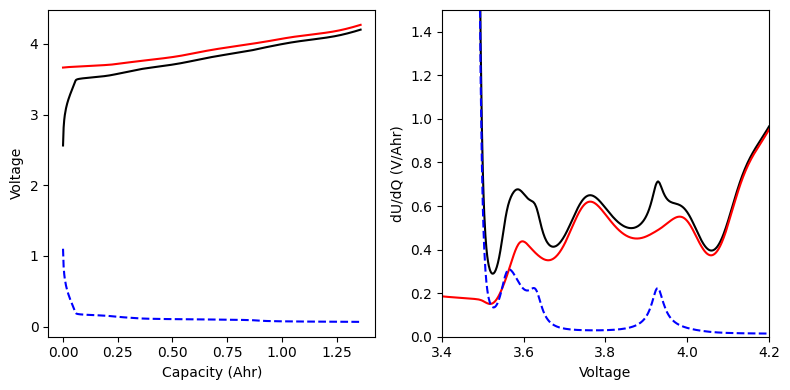

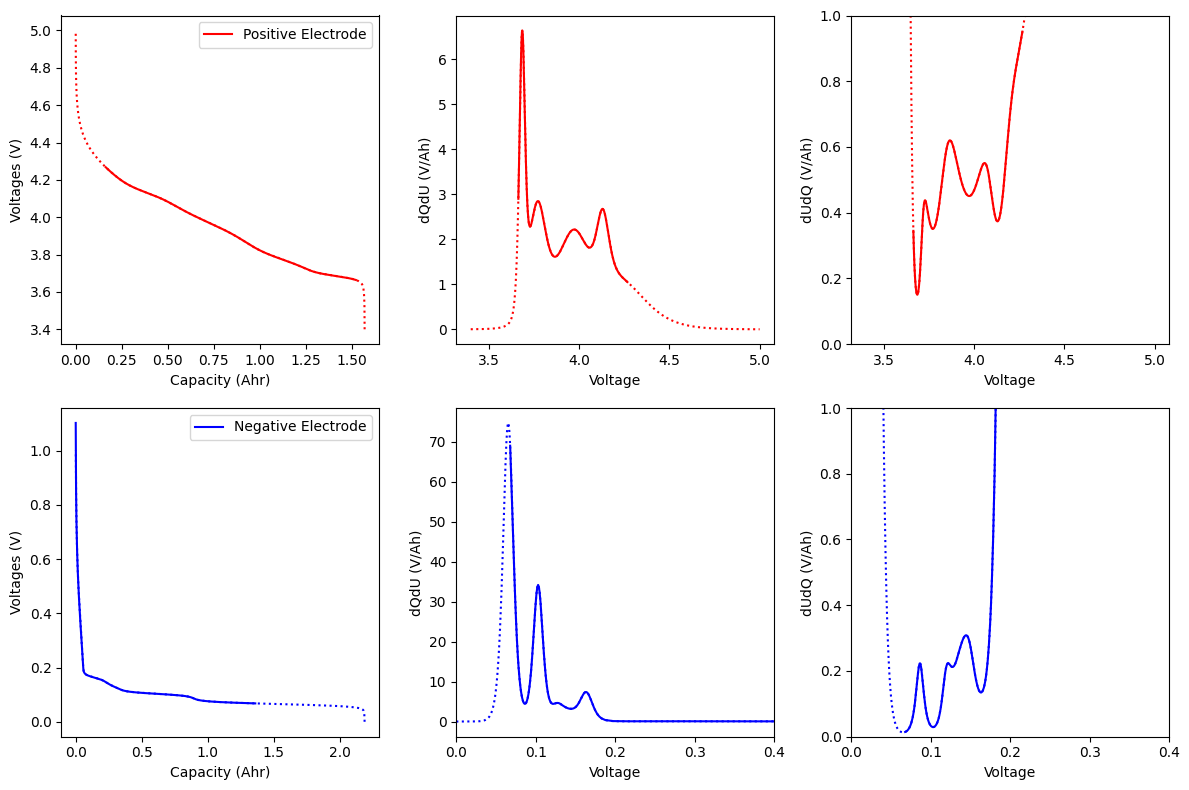

In [40]:
# 600 Cycles

guess_600 = results_600[0:(3*(nor_pos+nor_neg))]

model_results_600 = msmr.whole_cell(guess_600, nor_pos = 6, nor_neg = 6, 
                                 pos_lower_li_limit = results_600[-2], neg_lower_li_limit = results_600[-1],
                                 temp = 298, pos_volt_range = (3.4, 5), neg_volt_range = (0, 1), 
                                 usable_cap = Q_600.max(), n_p=None, p_capacity=None,
                                 Qj_or_Xj='Qj', all_output=True)

pos_whole_600 = msmr.electrode_response(guess_600[0:18], 298, 3.4, 5, 6)
neg_whole_600 = msmr.electrode_response(guess_600[18:36], 298, 0, 1, 6)

fig_1_600, fig_2_600 = mp.individual_electrode_analysis(model_results_600, pos_whole_600, neg_whole_600)

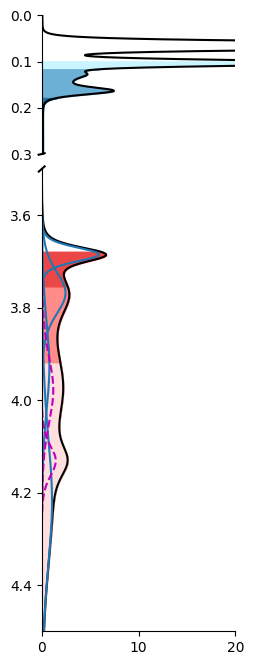

In [41]:
DOS_plot(Q_600,guess_600,results_600[-2],results_600[-1],'600_dos_charge.png')

#### MAE

In [42]:
whole_cell_600 = msmr.whole_cell(guess_600, nor_pos = 6, nor_neg = 6, 
                                 pos_lower_li_limit = results_600[-2], neg_lower_li_limit = results_600[-1],
                                 temp = 298, pos_volt_range = (3.4, 5), neg_volt_range = (0, 1), 
                                 usable_cap = Q_600.max(), n_p=None, p_capacity=None,
                                 Qj_or_Xj='Qj')

In [43]:
# fit0_51_mae_c = 
capacity_range_600 = np.linspace(Q_600.min(), Q_600.max(), 1000)
print ('Voltage profile MAE: ', msmr.mae(V_600, whole_cell_600[1], whole_cell_600[0], Q_600, capacity_range_600))
print ('dVdQ MAE: ',msmr.mae(dvdq_600, -whole_cell_600[3], whole_cell_600[1], V_600, V))
print ('dQdV MAE: ',msmr.mae(1/dvdq_600, -1/whole_cell_600[3], whole_cell_600[1], V_600, V))

Voltage profile MAE:  0.002809733873041829
dVdQ MAE:  0.019375694917739
dQdV MAE:  0.06667181782419768


### 900 cycles

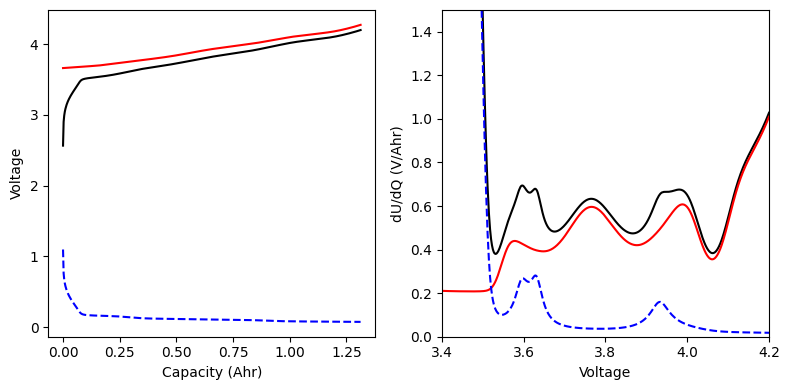

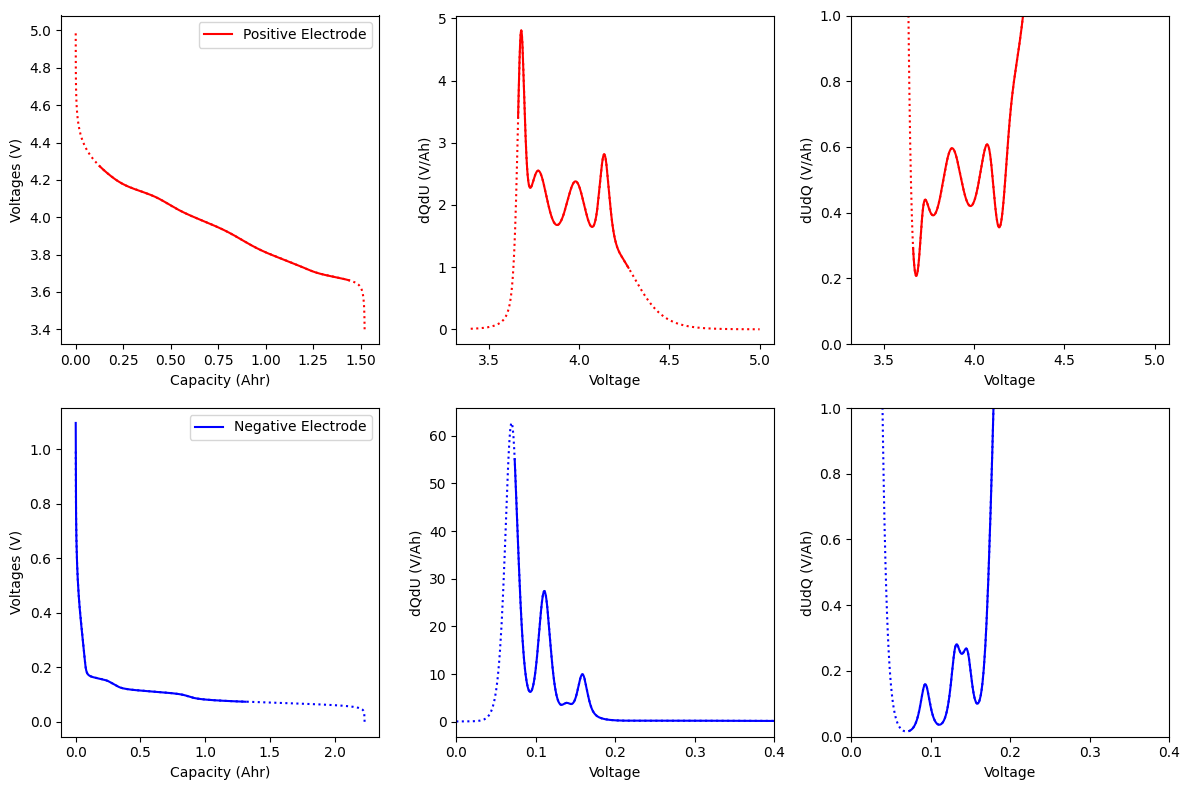

In [44]:
# 900 Cycles

guess_900 = results_900[0:(3*(nor_pos+nor_neg))]

model_results_900 = msmr.whole_cell(guess_900, nor_pos = 6, nor_neg = 6, 
                                 pos_lower_li_limit = results_900[-2], neg_lower_li_limit = results_900[-1],
                                 temp = 298, pos_volt_range = (3.4, 5), neg_volt_range = (0, 1), 
                                 usable_cap = Q_900.max(), n_p=None, p_capacity=None,
                                 Qj_or_Xj='Qj', all_output=True)

pos_whole_900 = msmr.electrode_response(guess_900[0:18], 298, 3.4, 5, 6)
neg_whole_900 = msmr.electrode_response(guess_900[18:36], 298, 0, 1, 6)

fig_1_900, fig_2_900 = mp.individual_electrode_analysis(model_results_900, pos_whole_900, neg_whole_900)

#### MAE

In [45]:
whole_cell_900 = msmr.whole_cell(guess_900, nor_pos = 6, nor_neg = 6, 
                                 pos_lower_li_limit = results_900[-2], neg_lower_li_limit = results_900[-1],
                                 temp = 298, pos_volt_range = (3.4, 5), neg_volt_range = (0, 1), 
                                 usable_cap = Q_900.max(), n_p=None, p_capacity=None,
                                 Qj_or_Xj='Qj')


In [46]:
# fit0_51_mae_c = 
capacity_range_900 = np.linspace(Q_900.min(), Q_900.max(), 1000)
print ('Voltage profile MAE: ', msmr.mae(V_900, whole_cell_900[1], whole_cell_900[0], Q_900, capacity_range_900))
print ('dVdQ MAE: ',msmr.mae(dvdq_900, -whole_cell_900[3], whole_cell_900[1], V_900, V))
print ('dQdV MAE: ',msmr.mae(1/dvdq_900, -1/whole_cell_900[3], whole_cell_900[1], V_900, V))

Voltage profile MAE:  0.0015241729775316503
dVdQ MAE:  0.012273697685021321
dQdV MAE:  0.03684721342212033


### 1500 Cycles

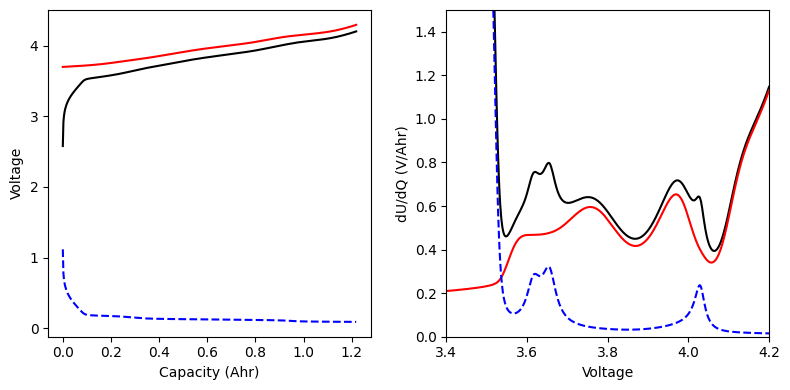

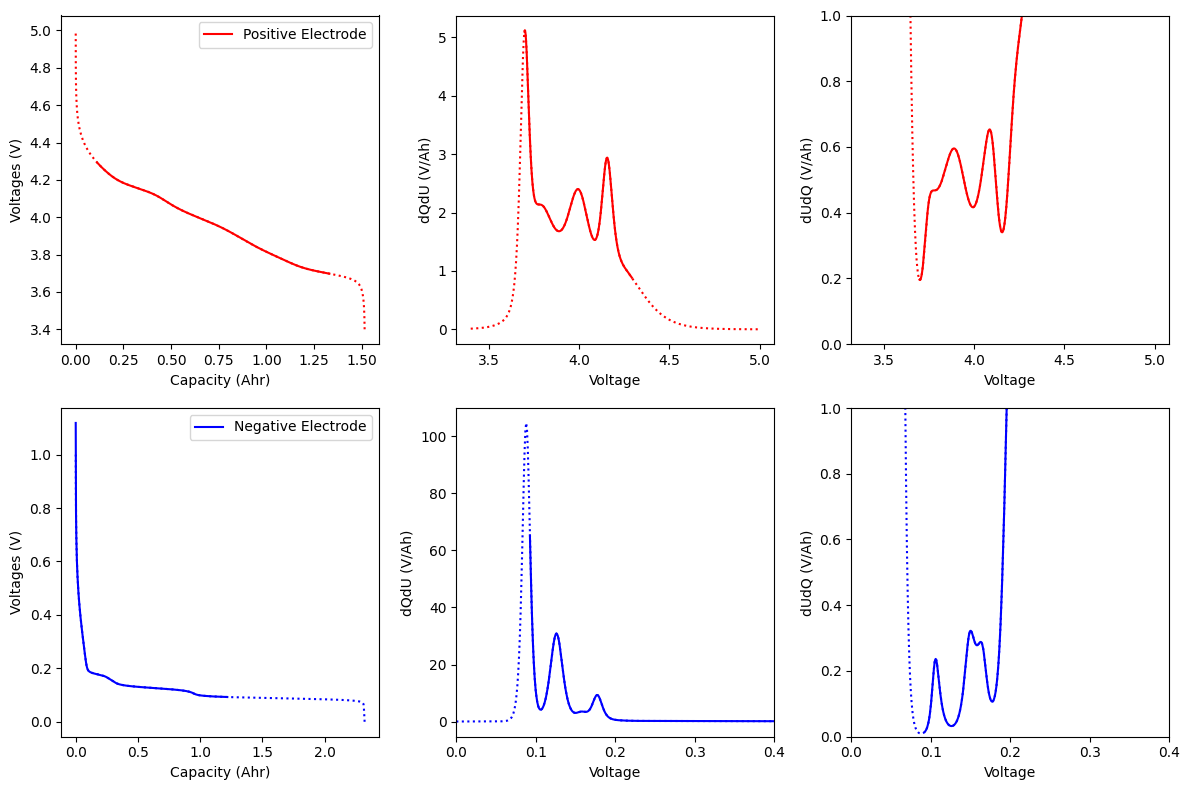

In [47]:
# 1500 Cycles

guess_1500 = results_1500[0:(3*(nor_pos+nor_neg))]

model_results_1500 = msmr.whole_cell(guess_1500, nor_pos = 6, nor_neg = 6, 
                                 pos_lower_li_limit = results_1500[-2], neg_lower_li_limit = results_1500[-1],
                                 temp = 298, pos_volt_range = (3.4, 5), neg_volt_range = (0, 1), 
                                 usable_cap = Q_1500.max(), n_p=None, p_capacity=None,
                                 Qj_or_Xj='Qj', all_output=True)

pos_whole_1500 = msmr.electrode_response(guess_1500[0:18], 298, 3.4, 5, 6)
neg_whole_1500 = msmr.electrode_response(guess_1500[18:36], 298, 0, 1, 6)

fig_1_1500, fig_2_1500 = mp.individual_electrode_analysis(model_results_1500, pos_whole_1500, neg_whole_1500)

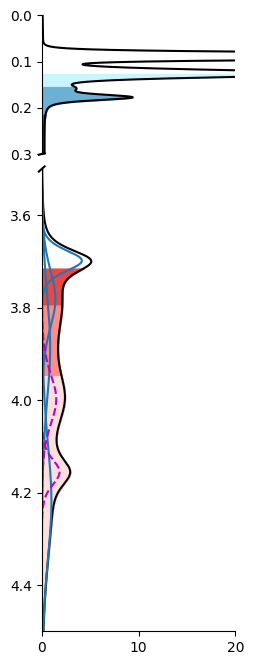

In [48]:
DOS_plot(Q_1500,guess_1500,results_1500[-2],results_1500[-1],'1500_dos_charge.png')

#### MAE

In [49]:
whole_cell_1500 = msmr.whole_cell(guess_1500, nor_pos = 6, nor_neg = 6, 
                                 pos_lower_li_limit = results_1500[-2], neg_lower_li_limit = results_1500[-1],
                                 temp = 298, pos_volt_range = (3.4, 5), neg_volt_range = (0, 1), 
                                 usable_cap = Q_1500.max(), n_p=None, p_capacity=None,
                                 Qj_or_Xj='Qj')

In [50]:
# fit0_51_mae_c = 
capacity_range_1500 = np.linspace(Q_1500.min(), Q_1500.max(), 1000)
print ('Voltage profile MAE: ', msmr.mae(V_1500, whole_cell_1500[1], whole_cell_1500[0], Q_1500, capacity_range_1500))
print ('dVdQ MAE: ',msmr.mae(dvdq_1500, -whole_cell_1500[3], whole_cell_1500[1], V_1500, V))
print ('dQdV MAE: ',msmr.mae(1/dvdq_1500, -1/whole_cell_1500[3], whole_cell_1500[1], V_1500, V))

Voltage profile MAE:  0.0027003807293837943
dVdQ MAE:  0.028054114383727426
dQdV MAE:  0.07341140861340496


## Comparison

### Summary

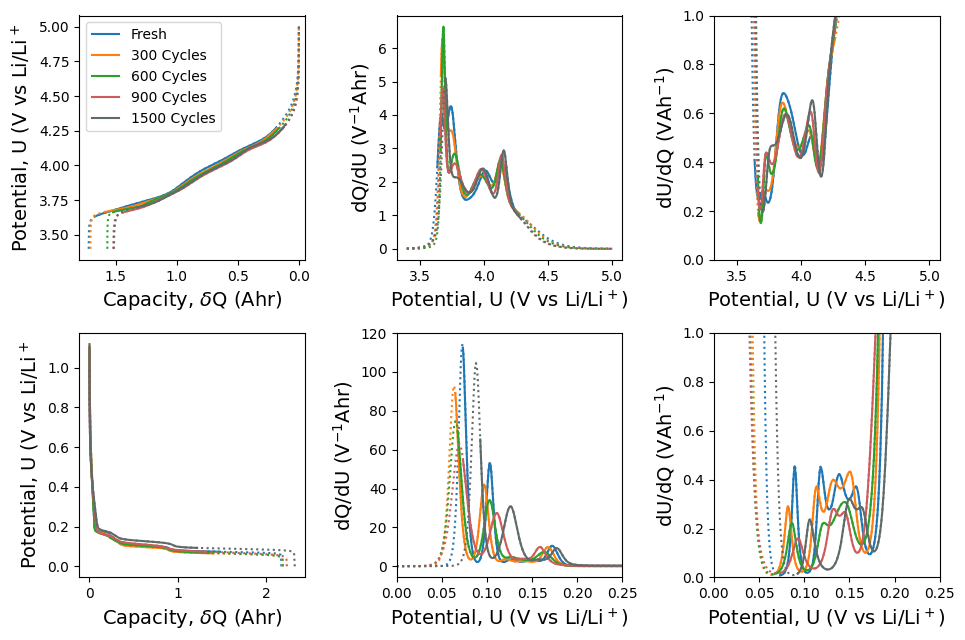

In [51]:
fig = plt.figure(figsize = (9.75, 6.5))

axe1, axe2, axe3 = fig.add_subplot(231), fig.add_subplot(232), fig.add_subplot(233)
axe4, axe5, axe6 = fig.add_subplot(234), fig.add_subplot(235), fig.add_subplot(236)

cap_ax, dqdu_ax, dudq_ax = [axe1, axe4], [axe2, axe5], [axe3, axe6]

color_map_2 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#CD5C5C', '#5F6A6A']
cycles = ['Fresh', '300 Cycles', '600 Cycles', '900 Cycles', '1500 Cycles']

# color_p = ['maroon', 'red', 'lightcoral'] # Different reds
# color_n = ['darkblue', 'blue', 'skyblue'] # Different blues

whole_cell_results = [model_results_f, model_results_300, model_results_600,model_results_900,model_results_1500]
pos_wholes = [pos_whole_0, pos_whole_300, pos_whole_600,pos_whole_900,pos_whole_1500]
neg_wholes = [neg_whole_0, neg_whole_300, neg_whole_600,neg_whole_900,neg_whole_1500]


for idx, i in enumerate(whole_cell_results):
    capacities, voltages, dqdus, dudqs = i[0], i[1], i[2], i[3]
    pv, pq, pd  = pos_wholes[idx]
    nv, nq, nd = neg_wholes[idx]
    
    axe1.plot(pq, pv, ':', color = color_map_2[idx])
    axe1.plot(capacities[1], voltages[1], color = color_map_2[idx], label=cycles[idx])

    axe2.plot(pv, -pd, ':', color = color_map_2[idx])
    axe2.plot(voltages[1], -dqdus[1], color = color_map_2[idx])

    axe3.plot(pv, -1/pd, ':', color = color_map_2[idx])
    axe3.plot(voltages[1], -dudqs[1], color = color_map_2[idx])

    axe4.plot(nq, nv, ':', color = color_map_2[idx])
    axe4.plot(capacities[2], voltages[2], color = color_map_2[idx], label=cycles[idx])

    axe5.plot(nv, -nd, ':', color = color_map_2[idx])
    axe5.plot(voltages[2], -dqdus[2], color = color_map_2[idx])

    axe6.plot(nv, -1/nd, ':', color = color_map_2[idx])
    axe6.plot(voltages[2], -dudqs[2], color = color_map_2[idx])

for axe in cap_ax:
    axe.set_xlabel('Capacity, $\delta$Q (Ahr)', fontsize=14)
    axe.set_ylabel('Potential, U (V vs Li/Li$^+$', fontsize=14)

for axe in dqdu_ax:
    axe.set_xlabel('Potential, U (V vs Li/Li$^+$)', fontsize=14)
    axe.set_ylabel('dQ/dU (V$^{-1}$Ahr)', fontsize=14)

for axe in dudq_ax:
    axe.set_xlabel('Potential, U (V vs Li/Li$^+$)', fontsize=14)
    axe.set_ylabel('dU/dQ (VAh$^{-1}$)', fontsize=14)
    axe.set_ylim(0,1)

axe1.set_xlim(1.8, -0.05)
axe1.legend(fontsize=10)
axe5.set_xlim(0,0.25)
axe6.set_xlim(0,0.25)
fig.tight_layout()

#fig.savefig('../figures/Figure 5/potential_new_figure_5.png', dpi = 300)

### Figure S3

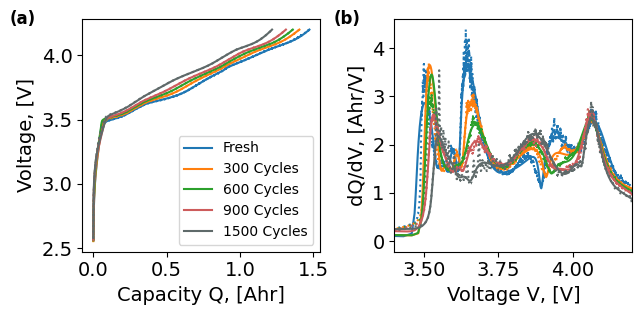

In [52]:
fig, ax = plt.subplots(1,2,figsize=(6.5,3.25))

Q_data = [Q_f,Q_300,Q_600,Q_900,Q_1500]
V_data = [V_f,V_300,V_600,V_900,V_1500]
dvdq_data =[dvdq_f,dvdq_300,dvdq_600,dvdq_900,dvdq_1500]
Q_interp_data = [Q_interp_f,Q_interp_300,Q_interp_600,Q_interp_900,Q_interp_1500]

for idx, i in enumerate(whole_cell_results):
    capacities, voltages, dqdus, dudqs = i[0], i[1], i[2], i[3]
    pv, pq, pd = pos_wholes[idx]
    nv, nq, nd = neg_wholes[idx]
    

    ax[0].plot(Q_data[idx], V_data[idx], ':', color = color_map_2[idx])
    ax[0].plot(capacities[0], voltages[0], '-', color = color_map_2[idx], label=cycles[idx])
    ax[1].plot(V_data[idx], 1/dvdq_data[idx], ':', color = color_map_2[idx])
    ax[1].plot(voltages[0], -1/dudqs[0], color = color_map_2[idx],label = cycles[idx])

ax[1].set_xlim(3.4, 4.2)

ax[0].set_xlabel('Capacity Q, [Ahr]', fontsize=14)
ax[0].set_ylabel('Voltage, [V]', fontsize=14)

ax[1].set_ylabel('dQ/dV, [Ahr/V]', fontsize=14)
ax[1].set_xlabel('Voltage V, [V]', fontsize=14)

ax[0].legend()
ax[0].tick_params(axis='x', which='major', labelsize=14) 
ax[0].tick_params(axis='y', which='major', labelsize=14) 
ax[1].tick_params(axis='x', which='major', labelsize=14) 
ax[1].tick_params(axis='y', which='major', labelsize=14) 
ax[0].text(-0.25, 1, '(a)',horizontalalignment='center',verticalalignment='center', transform=ax[0].transAxes, size=12, weight='bold')
ax[1].text(-0.2, 1, '(b)',horizontalalignment='center',verticalalignment='center', transform=ax[1].transAxes, size=12, weight='bold')

plt.tight_layout()
plt.show()
fig.savefig('figures/SI/Figure_S3.png', dpi = 300)


### Figure S4

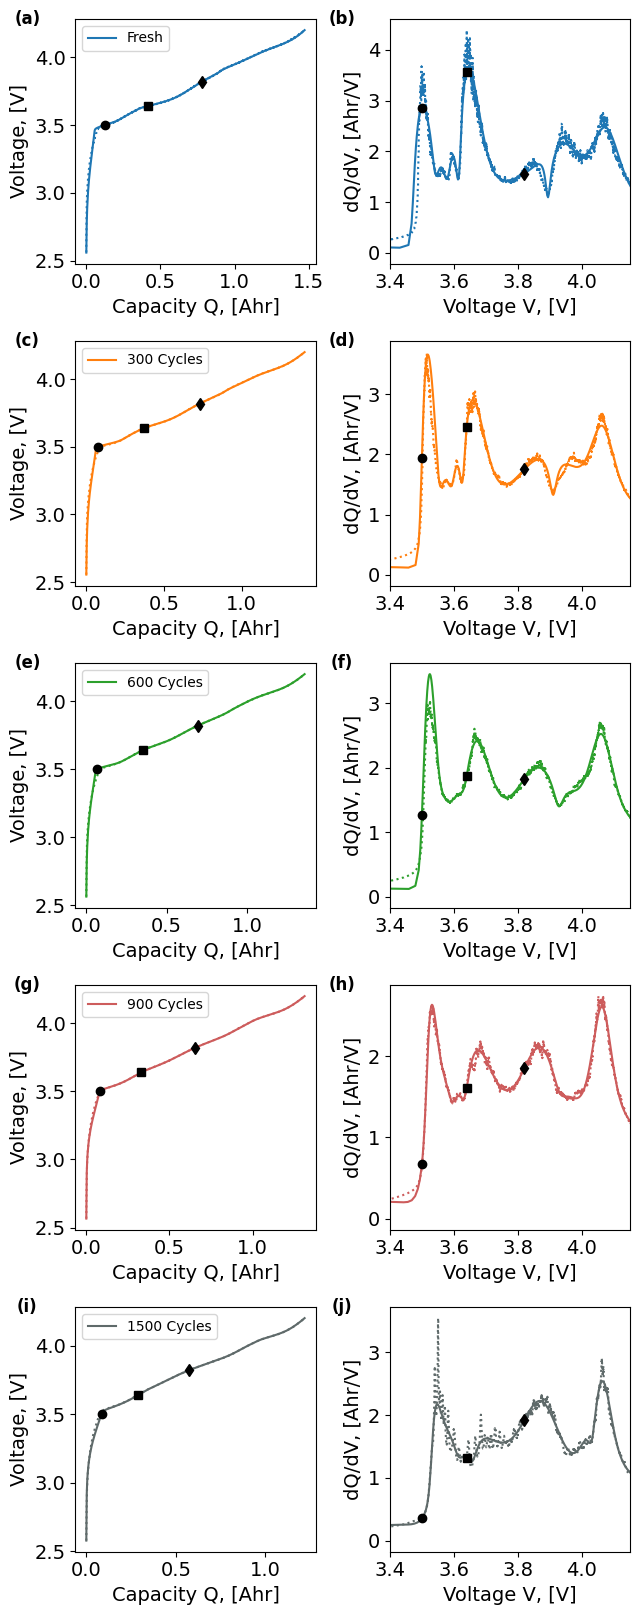

In [53]:
OCV = [3.5,3.64,3.82]

Q_data = [Q_f,Q_300,Q_600,Q_900,Q_1500]
V_data = [V_f,V_300,V_600,V_900,V_1500]
dvdq_data =[dvdq_f,dvdq_300,dvdq_600,dvdq_900,dvdq_1500]
markers = ['o','s','d']

fig, ax = plt.subplots(5,2,figsize = (6.5,3.25*5))

for idx, i in enumerate(whole_cell_results):

    capacities, voltages, dqdus, dudqs = i[0], i[1], i[2], i[3]
    pv, pq, pd = pos_wholes[idx]
    nv, nq, nd = neg_wholes[idx]

    ax[idx,0].plot(Q_data[idx], V_data[idx], ':', color = color_map_2[idx])
    ax[idx,0].plot(capacities[0], voltages[0], '-', color = color_map_2[idx], label=cycles[idx])
    ax[idx,1].plot(V_data[idx], 1/dvdq_data[idx], ':', color = color_map_2[idx])
    ax[idx,1].plot(voltages[0], -1/dudqs[0], color = color_map_2[idx],label = cycles[idx])

    [ax[idx,0].plot(np.interp(v, voltages[0], capacities[0]),v, marker=markers[num], color='k', linestyle='None') for num,v in enumerate(OCV)]
    [ax[idx,1].plot(v,np.interp(v, voltages[0], -1/dudqs[0]), marker=markers[num], color='k', linestyle='None') for num,v in enumerate(OCV)]

    ax[idx,1].set_xlim([3.4,4.15])
    
    
    ax[idx,0].set_xlabel('Capacity Q, [Ahr]', fontsize=14)
    ax[idx,0].set_ylabel('Voltage, [V]', fontsize=14)
    
    ax[idx,1].set_ylabel('dQ/dV, [Ahr/V]', fontsize=14)
    ax[idx,1].set_xlabel('Voltage V, [V]', fontsize=14)
    
    ax[idx,0].legend()
    ax[idx,0].tick_params(axis='x', which='major', labelsize=14) 
    ax[idx,0].tick_params(axis='y', which='major', labelsize=14) 
    ax[idx,1].tick_params(axis='x', which='major', labelsize=14) 
    ax[idx,1].tick_params(axis='y', which='major', labelsize=14) 
    ax[idx,0].text(-0.2, 1, '('+ascii_lowercase[idx*2]+')',horizontalalignment='center',verticalalignment='center', transform=ax[idx,0].transAxes, size=12, weight='bold')
    ax[idx,1].text(-0.2, 1, '('+ascii_lowercase[idx*2+1]+')',horizontalalignment='center',verticalalignment='center', transform=ax[idx,1].transAxes, size=12, weight='bold')

    plt.tight_layout()
plt.show()
fig.savefig('figures/SI/Figure_S4.png', dpi = 300)



### Figure S5

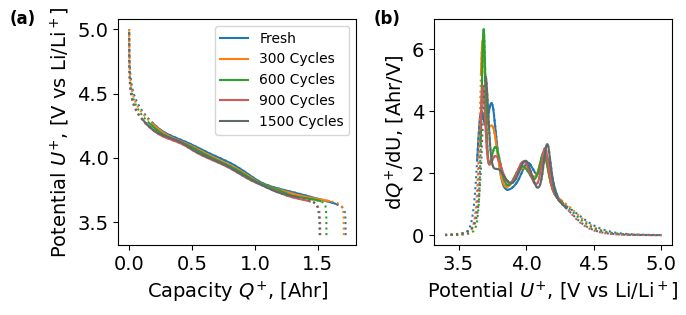

In [54]:
OCV = [3.5,3.64,3.82]

fig, ax = plt.subplots(1,2,figsize = (7, 3.25))

for idx, i in enumerate(whole_cell_results):
    capacities, voltages, dqdus, dudqs = i[0], i[1], i[2], i[3]
    pv, pq, pd = pos_wholes[idx]
    nv, nq, nd = neg_wholes[idx]

    ax[0].plot(pq, pv, ':', color = color_map_2[idx])
    ax[0].plot(capacities[1], voltages[1], color = color_map_2[idx], label=cycles[idx])

    ax[1].plot(pv, -pd, ':', color = color_map_2[idx])
    ax[1].plot(voltages[1], -dqdus[1], color = color_map_2[idx],label = cycles[idx])
# ax.set_xlim(1.8, -0.05)

ax[0].set_xlabel('Capacity $Q^{+}$, [Ahr]', fontsize=14)
ax[0].set_ylabel('Potential $U^{+}$, [V vs Li/Li$^+$]', fontsize=14)

ax[1].set_ylabel('d$Q^{+}$/dU, [Ahr/V]', fontsize=14)
ax[1].set_xlabel('Potential $U^{+}$, [V vs Li/Li$^+$]', fontsize=14)

ax[0].legend()
# ax[1].legend()
ax[0].tick_params(axis='x', which='major', labelsize=14) 
ax[0].tick_params(axis='y', which='major', labelsize=14) 
ax[1].tick_params(axis='x', which='major', labelsize=14) 
ax[1].tick_params(axis='y', which='major', labelsize=14) 

ax[0].text(-0.4, 1, '(a)',horizontalalignment='center',verticalalignment='center', transform=ax[0].transAxes, size=12, weight='bold')
ax[1].text(-0.2, 1, '(b)',horizontalalignment='center',verticalalignment='center', transform=ax[1].transAxes, size=12, weight='bold')

plt.tight_layout()
plt.show()
fig.savefig('figures/SI/Figure_S5.png', dpi = 300)


### Figure S6

Fresh[3.674 3.748 3.92 ]
300 Cycles[3.678 3.747 3.914]
600 Cycles[3.679 3.757 3.921]
900 Cycles[3.682 3.768 3.929]
1500 Cycles[3.715 3.795 3.948]


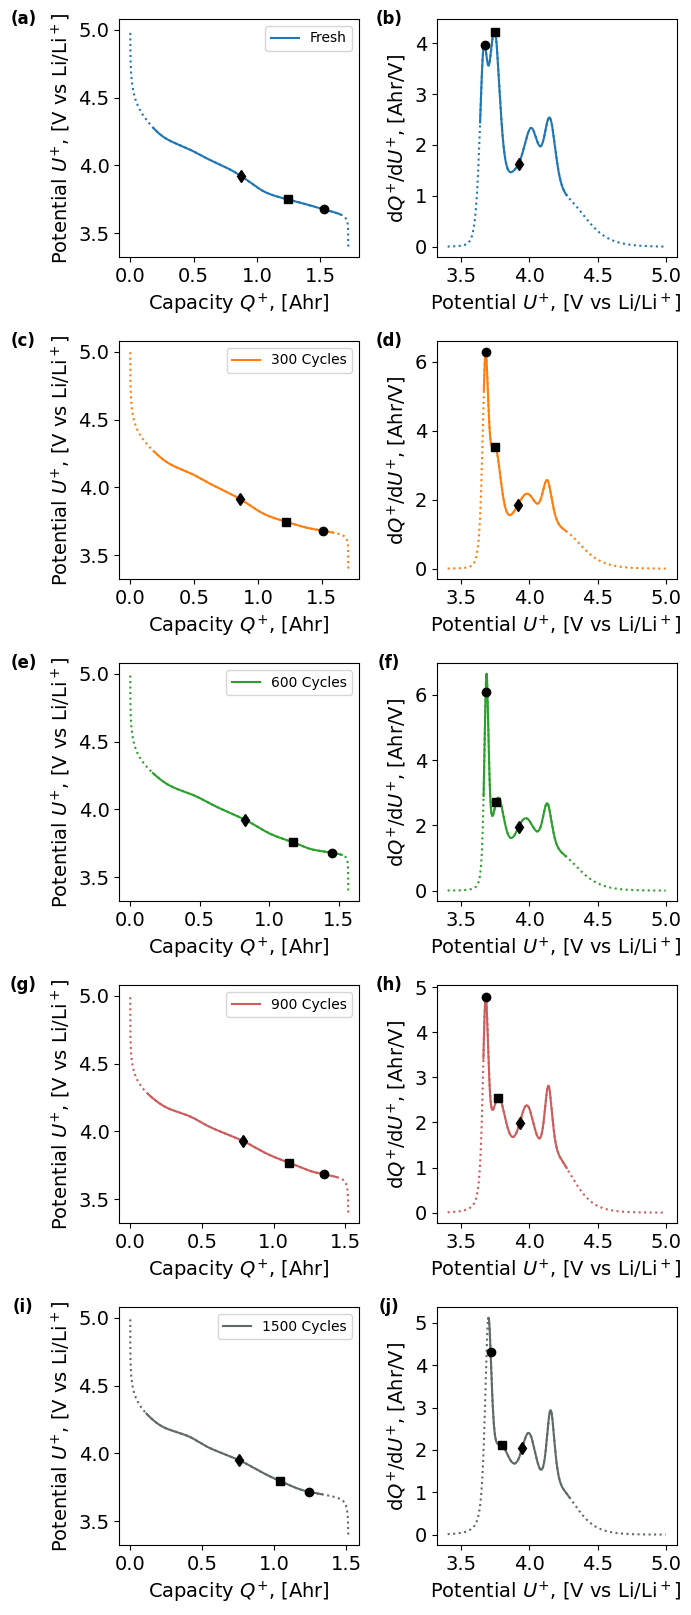

In [55]:
OCV = [3.5,3.64,3.82]
markers = ['o','s','d']
fig, ax = plt.subplots(5,2,figsize = (7,3.25*5))

for idx, i in enumerate(whole_cell_results):
    capacities, voltages, dqdus, dudqs = i[0], i[1], i[2], i[3]
    
    pv, pq, pd = pos_wholes[idx]
    nv, nq, nd = neg_wholes[idx]
    vsoc = np.interp(OCV, voltages[0], np.flip(voltages[1]))
    print(f'{cycles[idx]}{np.round(vsoc,3)}')

    panel_1 = idx*2
    panel_2 = idx*2+1
    ax[idx,0].plot(pq, pv, ':', color = color_map_2[idx])
    ax[idx,0].plot(capacities[1], voltages[1], color = color_map_2[idx], label=cycles[idx])
    
    ax[idx,1].plot(pv, -pd, ':', color = color_map_2[idx])

    ax[idx,1].plot(voltages[1], -1/dudqs[1], color = color_map_2[idx],label = cycles[idx])
    [ax[idx,0].plot(np.interp(v, pv, pq), v, marker=markers[num], color='k', linestyle='None') for num,v in enumerate(vsoc)]

    [ax[idx,1].plot(v,np.interp(v, pv, -pd), marker=markers[num], color='k', linestyle='None') for num,v in enumerate(vsoc)]

    ax[idx,0].set_xlabel('Capacity $Q^{+}$, [Ahr]', fontsize=14)
    ax[idx,0].set_ylabel('Potential $U^{+}$, [V vs Li/Li$^+$]', fontsize=14)
    
    ax[idx,1].set_ylabel('d$Q^{+}$/d$U^{+}$, [Ahr/V]', fontsize=14)
    ax[idx,1].set_xlabel('Potential $U^{+}$, [V vs Li/Li$^+$] ', fontsize=14)
    
    ax[idx,0].legend()
    ax[idx,0].tick_params(axis='x', which='major', labelsize=14) 
    ax[idx,0].tick_params(axis='y', which='major', labelsize=14) 
    ax[idx,1].tick_params(axis='x', which='major', labelsize=14) 
    ax[idx,1].tick_params(axis='y', which='major', labelsize=14) 
    ax[idx,0].text(-0.4, 1, '('+ascii_lowercase[idx*2]+')',horizontalalignment='center',verticalalignment='center', transform=ax[idx,0].transAxes, size=12, weight='bold')
    ax[idx,1].text(-0.2, 1, '('+ascii_lowercase[idx*2+1]+')',horizontalalignment='center',verticalalignment='center', transform=ax[idx,1].transAxes, size=12, weight='bold')

    plt.tight_layout()
plt.show()
fig.savefig('figures/SI/Figure_S6.png', dpi = 300)



### Figure S7

Fresh[0.174 0.108 0.1  ]
300 Cycles[0.178 0.107 0.094]
600 Cycles[0.179 0.117 0.101]
900 Cycles[0.182 0.128 0.109]
1500 Cycles[0.215 0.155 0.128]


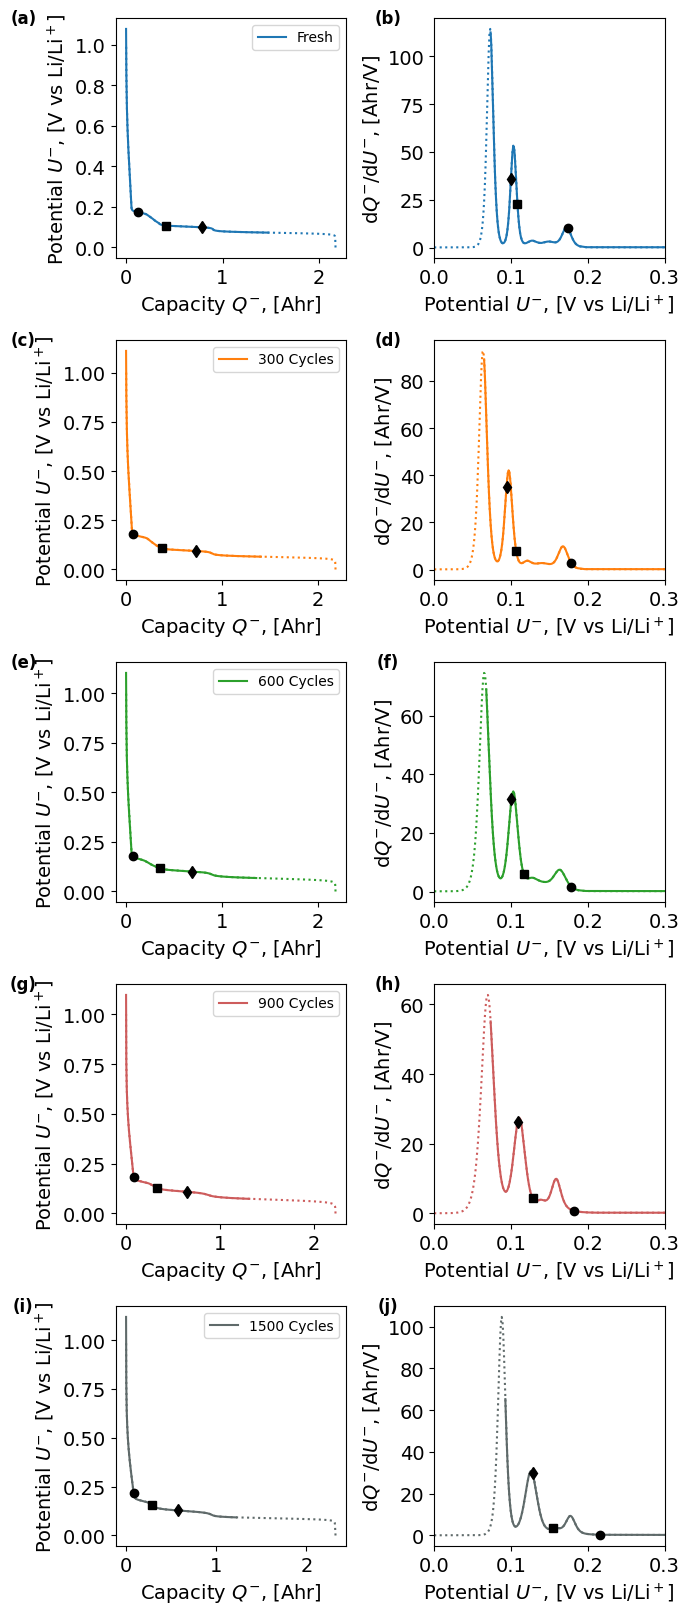

In [56]:
OCV = [3.5,3.64,3.82]
markers = ['o','s','d']
fig, ax = plt.subplots(5,2,figsize = (7,3.25*5))

for idx, i in enumerate(whole_cell_results):
    capacities, voltages, dqdus, dudqs = i[0], i[1], i[2], i[3]
    
    pv, pq, pd = pos_wholes[idx]
    nv, nq, nd = neg_wholes[idx]
    vsoc = np.interp(OCV, voltages[0], voltages[2])
    print(f'{cycles[idx]}{np.round(vsoc,3)}')
    panel_1 = idx*2
    panel_2 = idx*2+1
    ax[idx,0].plot(nq, nv, ':', color = color_map_2[idx])
    ax[idx,0].plot(capacities[2], voltages[2], color = color_map_2[idx], label=cycles[idx])
    
    ax[idx,1].plot(nv, -nd, ':', color = color_map_2[idx])

    ax[idx,1].plot(voltages[2], -1/dudqs[2], color = color_map_2[idx],label = cycles[idx])
    [ax[idx,0].plot(np.interp(v, nv, nq), v, marker=markers[num], color='k', linestyle='None') for num,v in enumerate(vsoc)]

    [ax[idx,1].plot(v,np.interp(v, nv, -nd), marker=markers[num], color='k', linestyle='None') for num,v in enumerate(vsoc)]

    ax[idx,0].set_xlabel('Capacity $Q^{-}$, [Ahr]', fontsize=14)
    ax[idx,0].set_ylabel('Potential $U^{-}$, [V vs Li/Li$^+$]', fontsize=14)
    
    ax[idx,1].set_ylabel('d$Q^{-}$/d$U^{-}$, [Ahr/V]', fontsize=14)
    ax[idx,1].set_xlabel('Potential $U^{-}$, [V vs Li/Li$^+$] ', fontsize=14)

    ax[idx,1].set_xlim([0, 0.3]) 

    ax[idx,0].legend()
    ax[idx,0].tick_params(axis='x', which='major', labelsize=14) 
    ax[idx,0].tick_params(axis='y', which='major', labelsize=14) 
    ax[idx,1].tick_params(axis='x', which='major', labelsize=14) 
    ax[idx,1].tick_params(axis='y', which='major', labelsize=14) 
    ax[idx,0].text(-0.4, 1, '('+ascii_lowercase[idx*2]+')',horizontalalignment='center',verticalalignment='center', transform=ax[idx,0].transAxes, size=12, weight='bold')
    ax[idx,1].text(-0.2, 1, '('+ascii_lowercase[idx*2+1]+')',horizontalalignment='center',verticalalignment='center', transform=ax[idx,1].transAxes, size=12, weight='bold')

    plt.tight_layout()
plt.show()
fig.savefig('figures/SI/Figure_S7.png', dpi = 300)

